#### Importing Libraries

In [16]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as web
import scipy.optimize as sco

#### Getting Historical Stock Price Data

Historical price data is taken from Yahoo Finance using pandas_datareader library. Here, only Adjusted Close price will be used to generate the Optimal Portfolio

In [17]:
stocks = []

num_stocks = int(input("Enter Number of Stocks in the Portfolio: "))

for i in range(0, num_stocks):
    x = (str(input("Enter Stock Name: ")))
    stocks.append(x)

start_date = str(input("Enter Start Date for Historical Stock Price (YYYY-MM-DD): "))
end_date = str(input("Enter End Date for Historical Stock Price (YYYY-MM-DD): "))

    

stock_data = web.get_data_yahoo(stocks,
                           start = start_date,
                           end = end_date)['Adj Close']

stock_data.head()

Enter Number of Stocks in the Portfolio: 5
Enter Stock Name: AMZN
Enter Stock Name: JNJ
Enter Stock Name: TSLA
Enter Stock Name: AAPL
Enter Stock Name: GOOGL
Enter Start Date for Historical Stock Price (YYYY-MM-DD): 2020-01-01
Enter End Date for Historical Stock Price (YYYY-MM-DD): 2020-11-30


Symbols,AAPL,AMZN,GOOGL,JNJ,TSLA
Date,,,,,
2019-12-31,72.192863,1847.839966,1339.390015,142.009354,83.666000
2020-01-02,73.840042,1898.010010,1368.680054,142.106705,86.052002
2020-01-03,73.122154,1874.969971,1361.520020,140.461426,88.601997
2020-01-06,73.704819,1902.880005,1397.810059,140.286209,90.307999
2020-01-07,73.358185,1906.859985,1395.109985,141.142899,93.811996


**Plotting the Stock Price**

Text(0, 0.5, 'Stock Price')

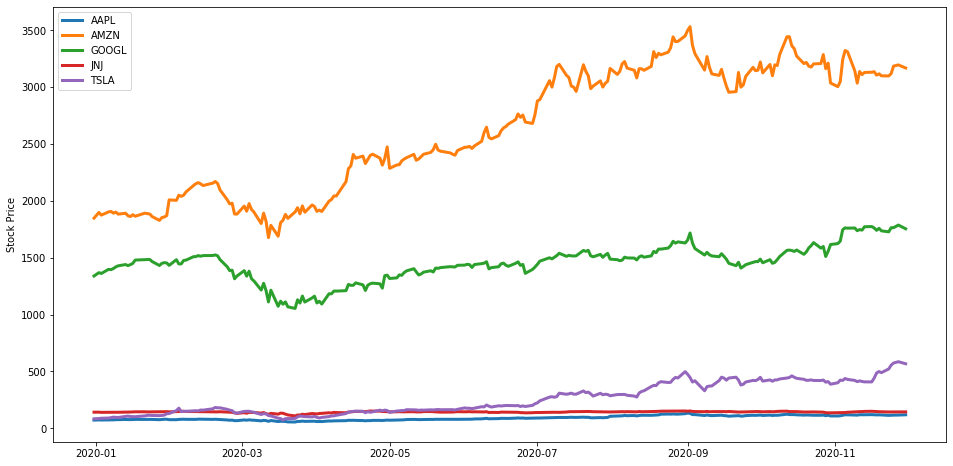

In [18]:
plt.figure(figsize=(16, 8))
for c in stock_data.columns.values:
    plt.plot(stock_data.index, stock_data[c], lw=3, alpha=1,label=c)
plt.legend(loc='upper left', fontsize=10)
plt.ylabel('Stock Price')

In [19]:
## Calculating the daily percentage change in the returns
returns = stock_data.pct_change()

**Plotting the Percentage Change**

Text(0, 0.5, 'Daily returns')

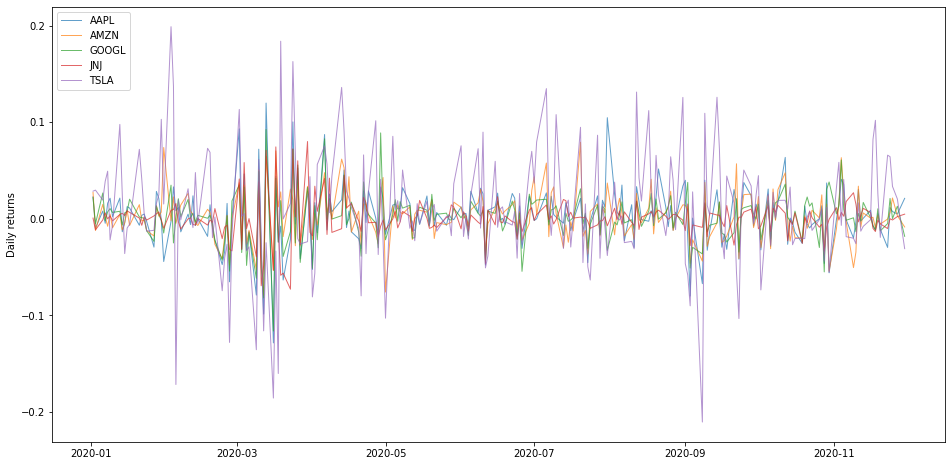

In [20]:
plt.figure(figsize=(16, 8))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=1, alpha=0.7,label=c)
plt.legend(loc='upper left', fontsize=10)
plt.ylabel('Daily returns')

This calculates the expected mean of return and volatility for a portolio of assets for a given weight matrix

In [21]:
def annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

**Note:** Assuming trading days equal to 252 in a year

In [23]:
returns = stock_data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_port = int(input('Enter the number of Random Portfolios: '))
risk_free_rate = float(input('Enter the risk-free rate: '))

Enter the number of Random Portfolios: 25000
Enter the risk-free rate: 0.0012


### Portfolio Optimization using Scipy

Since there is no Maximize function available in Scipy to maximize the Sharpe-Ratio of the portfolio, minimize() function is used instead on a negative Sharpe-Ratio

In [24]:
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

*Optimization constraint:* Sum of Weight of Stock in the portfolio is equal to one

In [25]:
def maximum_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_stocks))
    result = sco.minimize(negative_sharpe_ratio, num_stocks*[1./num_stocks,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

**Minimum Variance Portfolio:**  Getting the minimum variance portfolio by minimizing the portfolio volatility

In [26]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return annualised_performance(weights, mean_returns, cov_matrix)[0]

*Optimization constraint:* Sum of Weight of Stock in the portfolio is equal to one

In [27]:
def minimum_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_stocks))

    result = sco.minimize(portfolio_volatility, num_stocks*[1./num_stocks,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

**Calculating Efficient Portfolios**

*Optimization constraint:* 

1. Sum of Weight of Stock in the portfolio is equal to one
2. Portfolio Return should be equal to the target return

In [28]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_stocks))
    result = sco.minimize(portfolio_volatility, num_stocks*[1./num_stocks,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

**Generating Random Portfolios:** This is to the randomly simulated portfolio with different risk-reward pay-offs and to highlight the **Efficient Frontier** on these portfolios

In [29]:
def random_portfolios(num_port, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_port))
    weights_record = []
    for i in range(num_port):
        weights = np.random.random(num_stocks)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [32]:
def display_ef(mean_returns, cov_matrix, num_port, risk_free_rate):
    results, _ = random_portfolios(num_port,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = maximum_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_pf = pd.DataFrame(max_sharpe.x,index=stock_data.columns,columns=['weights'])
    max_sharpe_pf.weights = [round(i*100,2)for i in max_sharpe_pf.weights]
    max_sharpe_pf = max_sharpe_pf.T
    max_sharpe_pf

    min_vol = minimum_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_pf = pd.DataFrame(min_vol.x,index=stock_data.columns,columns=['weights'])
    min_vol_pf.weights = [round(i*100,2)for i in min_vol_pf.weights]
    min_vol_pf = min_vol_pf.T
    
    print ("-"*40)
    print ("Max Sharpe Ratio Portfolio\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_pf)
    print ("-"*40)
    print ("Min Volatility Portfolio\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_pf)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, rp, 500)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

----------------------------------------
Max Sharpe Ratio Portfolio

Annualised Return: 1.95
Annualised Volatility: 0.7


Symbols  AAPL   AMZN  GOOGL  JNJ   TSLA
weights   0.0  30.68    0.0  0.0  69.32
----------------------------------------
Min Volatility Portfolio

Annualised Return: 0.24
Annualised Volatility: 0.29


Symbols  AAPL   AMZN  GOOGL    JNJ  TSLA
weights   0.0  29.38    0.0  70.62   0.0


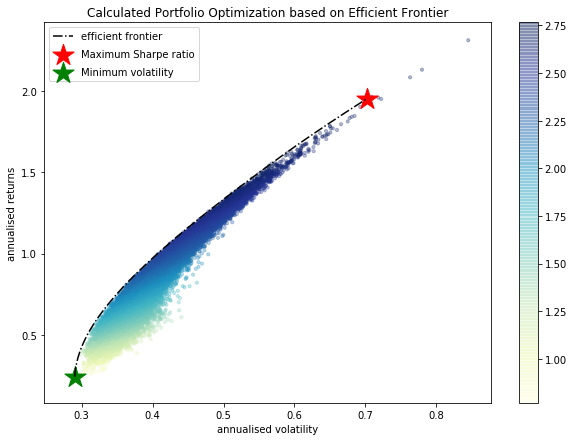

In [33]:
display_ef(mean_returns, cov_matrix, num_port, risk_free_rate)